# Variational inference for RNA velocity with VeloVI

In [1]:
!pip install --quiet scvi-colab
from scvi_colab import install

install()

/home/adam/miniconda3/envs/velovi_conda/lib/python3.9/site-packages/scvi_colab/_core.py:41: UserWarning: 
                Not currently in Google Colab environment.

                Please run with `run_outside_colab=True` to override.

                Returning with no further action.
                
  warn(


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import seaborn as sns
import torch
from velovi import VELOVI, preprocess_data

Global seed set to 0


## Load and preprocess data

In [3]:
adata = scv.datasets.pancreas()

In [4]:
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 21611 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:03) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [5]:
adata = preprocess_data(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


## Train and apply model

In [6]:
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)
vae.train()

/home/adam/miniconda3/envs/velovi_conda/lib/python3.9/site-packages/torch/distributed/_sharded_tensor/__init__.py:8: DeprecationWarning: torch.distributed._sharded_tensor will be deprecated, use torch.distributed._shard.sharded_tensor instead
  warnings.warn(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 405/500:  81%|████████  | 405/500 [01:16<00:17,  5.31it/s, loss=-2.4e+03, v_num=1] 
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -2330.793. Signaling Trainer to stop.


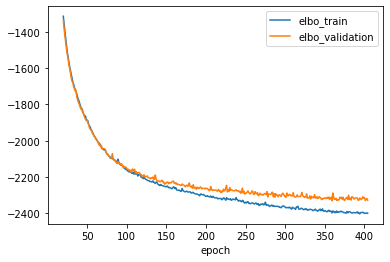

In [7]:
fig, ax = plt.subplots()
vae.history["elbo_train"].iloc[20:].plot(ax=ax, label="train")
vae.history["elbo_validation"].iloc[20:].plot(ax=ax, label="validation")
plt.legend()

### Get model outputs

In [8]:
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr).detach().cpu().numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var["fit_scaling"] = 1.0


add_velovi_outputs_to_adata(adata, vae)

In [9]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/20 cores)


  0%|          | 0/3696 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


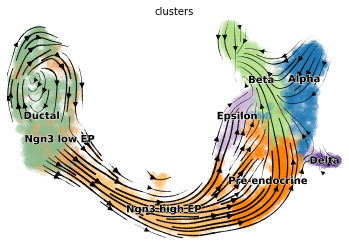

In [10]:
scv.pl.velocity_embedding_stream(adata, basis="umap")

### Intrinsic uncertainty

In [11]:
uncertainty_df, _ = vae.get_directional_uncertainty(n_samples=100)
uncertainty_df.head()

INFO     velovi: Sampling from model...                                                      
INFO     velovi: Computing the uncertainties...                                              


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 808 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 3537 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 3657 out of 3696 | elapsed:    7.9s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    7.9s finished


,directional_variance,directional_difference,directional_cosine_sim_variance,directional_cosine_sim_difference,directional_cosine_sim_mean
index,,,,,
AAACCTGAGAGGGATA,0.000992,0.099744,0.000558,0.074686,0.663482
AAACCTGAGCCTTGAT,0.001516,0.122854,0.000897,0.094864,0.637474
AAACCTGAGGCAATTA,0.001124,0.108947,0.000674,0.083901,0.639332
AAACCTGCATCATCCC,0.001043,0.103214,0.000584,0.077158,0.664519
AAACCTGGTAAGTGGC,0.001091,0.109103,0.000600,0.080870,0.676792


In [12]:
for c in uncertainty_df.columns:
    adata.obs[c] = np.log10(uncertainty_df[c].values)

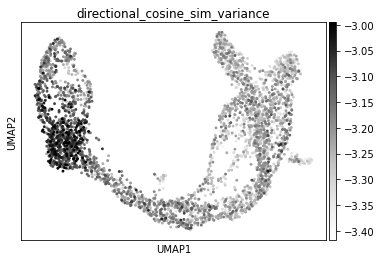

In [21]:
sc.pl.umap(
    adata,
    color="directional_cosine_sim_variance",
    cmap="Greys",
    vmin="p1",
    vmax="p99",
)

### Extrinsic uncertainty

In [14]:
def compute_extrinisic_uncertainty(adata, vae, n_samples=25) -> pd.DataFrame:
    import io
    from contextlib import redirect_stdout

    from scvi.utils import track
    from velovi._model import _compute_directional_statistics_tensor

    extrapolated_cells_list = []
    for i in track(range(n_samples)):
        with io.StringIO() as buf, redirect_stdout(buf):
            vkey = f"velocities_velovi_{i}"
            v = vae.get_velocity(n_samples=1, velo_statistic="mean")
            adata.layers[vkey] = v
            scv.tl.velocity_graph(adata, vkey=vkey, sqrt_transform=False, approx=True)
            t_mat = scv.utils.get_transition_matrix(
                adata, vkey=vkey, self_transitions=True, use_negative_cosines=True
            )
            extrapolated_cells = np.asarray(t_mat @ adata.layers["Ms"])
            extrapolated_cells_list.append(extrapolated_cells)
    extrapolated_cells = np.stack(extrapolated_cells_list)
    df = _compute_directional_statistics_tensor(extrapolated_cells, n_jobs=-1, n_cells=adata.n_obs)
    return df

In [15]:
ext_uncertainty_df = compute_extrinisic_uncertainty(adata, vae)

Working...:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   4%|▍         | 1/25 [00:01<00:36,  1.53s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:   8%|▊         | 2/25 [00:03<00:35,  1.55s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  12%|█▏        | 3/25 [00:04<00:33,  1.54s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  16%|█▌        | 4/25 [00:06<00:32,  1.54s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  20%|██        | 5/25 [00:07<00:31,  1.56s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  24%|██▍       | 6/25 [00:09<00:29,  1.56s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  28%|██▊       | 7/25 [00:10<00:28,  1.56s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  32%|███▏      | 8/25 [00:12<00:26,  1.56s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  36%|███▌      | 9/25 [00:14<00:24,  1.56s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  40%|████      | 10/25 [00:15<00:23,  1.54s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  44%|████▍     | 11/25 [00:17<00:21,  1.55s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  48%|████▊     | 12/25 [00:18<00:20,  1.61s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  52%|█████▏    | 13/25 [00:20<00:18,  1.57s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  56%|█████▌    | 14/25 [00:21<00:17,  1.55s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  60%|██████    | 15/25 [00:23<00:15,  1.53s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  64%|██████▍   | 16/25 [00:24<00:13,  1.51s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  68%|██████▊   | 17/25 [00:26<00:12,  1.50s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  72%|███████▏  | 18/25 [00:27<00:10,  1.50s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  76%|███████▌  | 19/25 [00:29<00:08,  1.50s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  80%|████████  | 20/25 [00:30<00:07,  1.47s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  84%|████████▍ | 21/25 [00:32<00:05,  1.47s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  88%|████████▊ | 22/25 [00:33<00:04,  1.45s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  92%|█████████▏| 23/25 [00:34<00:02,  1.44s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...:  96%|█████████▌| 24/25 [00:36<00:01,  1.45s/it]

  0%|          | 0/3696 [00:00<?, ?cells/s]

Working...: 100%|██████████| 25/25 [00:37<00:00,  1.51s/it]
INFO     velovi: Computing the uncertainties...                                              


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2344 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 3696 out of 3696 | elapsed:    0.8s finished


In [16]:
for c in ext_uncertainty_df.columns:
    adata.obs[c + "_extrinisic"] = np.log10(ext_uncertainty_df[c].values)

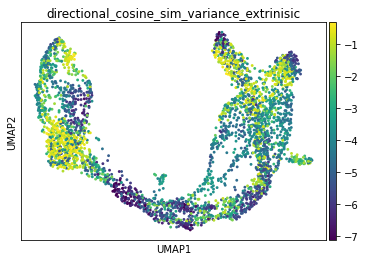

In [17]:
sc.pl.umap(
    adata,
    color="directional_cosine_sim_variance_extrinisic",
    vmin="p1",
    vmax="p99",
)

### Permutation score

In [19]:
perm_df, _ = vae.get_permutation_scores(labels_key="clusters")
adata.var["permutation_score"] = perm_df.max(1).values

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       
INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup       


<AxesSubplot:xlabel='permutation_score', ylabel='Density'>

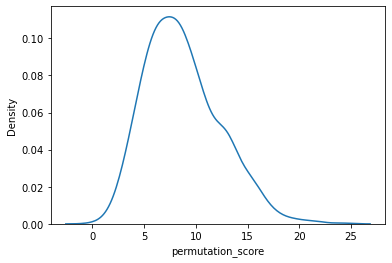

In [20]:
sns.kdeplot(data=adata.var, x="permutation_score")